# Dataset Creation

- Using Vincent Van Gogh's artwork generate a series of paired images that are composed of a sketch and the true image.
- Add all data to a tensorflow dataset object and save.

### Setup

In [1]:
from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
import cv2
import numpy as np
from random import shuffle
import pickle

In [2]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1

IMG_DIR ='./wikiart/wikiart-saved/'
IMG_EXTENSIONS = ['.png', '.jpg', '.jpeg']

TRAINING_RATIO = 0.8

DATASET_SAVE_PATH = './Dataset'

### Load Images

Load images from directory which are horizontal and generate image paths.

Rotating an image in windows by right-clicking and using the 'rotate-left' and 'rotate-right' options do no change the orientation of the image according to PIL. This is due to EXIF tags and to obtain the correct result, edit the image itself in an image editor.

In [3]:
images_paths = set()
images_to_remove = set()

for ext in IMG_EXTENSIONS:
  images_paths = images_paths.union(Path(IMG_DIR).glob(f'**/*{ext}'))


for image_path in images_paths:
  image = Image.open(image_path)
  if image.size[0] < image.size[1]:
    images_to_remove.add(image_path)


images_paths.difference_update(images_to_remove)
images_paths = [str(image_path) for image_path in images_paths]


In [4]:
for image_path in images_paths[:10]:
    print(image_path)

wikiart\wikiart-saved\images\vincent-van-gogh\1888\207165.jpg
wikiart\wikiart-saved\images\vincent-van-gogh\1888\205924.jpg
wikiart\wikiart-saved\images\vincent-van-gogh\1884\207140.jpg
wikiart\wikiart-saved\images\vincent-van-gogh\1890\206605.jpg
wikiart\wikiart-saved\images\vincent-van-gogh\1890\206867.jpg
wikiart\wikiart-saved\images\vincent-van-gogh\1889\205905.jpg
wikiart\wikiart-saved\images\vincent-van-gogh\1882\206838.jpg
wikiart\wikiart-saved\images\vincent-van-gogh\1888\206142.jpg
wikiart\wikiart-saved\images\vincent-van-gogh\1881\206332.jpg
wikiart\wikiart-saved\images\vincent-van-gogh\1876\207339.jpg


In [5]:
num_training = round(len(images_paths) * TRAINING_RATIO)
num_testing = len(images_paths) - num_training

shuffle(images_paths)

training_images = images_paths[:num_training]
testing_images = images_paths[num_training:]

In [6]:
print(f'Number of images in training: {len(training_images)}')
print(f'Number of images in testing: {len(testing_images)}')
print(f'Total number of images: {len(images_paths)}, Sum adds properly: {len(training_images) + len(testing_images) == len(images_paths)}')

Number of images in training: 793
Number of images in testing: 198
Total number of images: 991, Sum adds properly: True


Open a sample image.

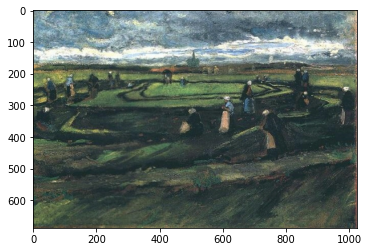

In [7]:
sample_image = tf.io.read_file((images_paths[0]))
sample_image = tf.io.decode_jpeg(sample_image)

plt.imshow(sample_image)

### Convert Images to Sketches

Using OpenCV convert image to grayscale, invert it and divide by inverted gaussian blur to get sketch like effect. This function must be executed as a tf.py_function.

In [8]:
def image_to_sketch(image):

   grey_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
   invert = cv2.bitwise_not(grey_img)

   blur = cv2.GaussianBlur(invert, (21, 21), 0)
   invertedblur = cv2.bitwise_not(blur)
   sketch = cv2.divide(grey_img, invertedblur, scale=256.0)

   sketch = cv2.cvtColor(sketch, cv2.COLOR_GRAY2BGR)

   return sketch


### Stitch Sketch to Regular Image

In [19]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

stiched_images_paths = []

for image_index, image_path in enumerate(images_paths):

    index = images_paths[0].rfind('.')
    stiched_file_name = image_path[:index] + '-stiched' + image_path[index:]
    stiched_images_paths.append(stiched_file_name)
    
    if cv2.imread(stiched_file_name) is not None:
        print(f'image {image_index} already present')
        continue
    
    print(stiched_file_name)
    
    image = cv2.imread(image_path)
    sketch = image_to_sketch(image)
    
    concatenated_image = np.hstack((image, sketch))

    cv2.imwrite(stiched_file_name, concatenated_image)

image 0 already present
image 1 already present
image 2 already present
image 3 already present
image 4 already present
image 5 already present
image 6 already present
image 7 already present
image 8 already present
image 9 already present
image 10 already present
image 11 already present
image 12 already present
image 13 already present
image 14 already present
image 15 already present
image 16 already present
image 17 already present
image 18 already present
image 19 already present
image 20 already present
image 21 already present
image 22 already present
image 23 already present
image 24 already present
image 25 already present
image 26 already present
image 27 already present
image 28 already present
image 29 already present
image 30 already present
image 31 already present
image 32 already present
image 33 already present
image 34 already present
image 35 already present
image 36 already present
image 37 already present
image 38 already present
image 39 already present
image 40 a

image 322 already present
image 323 already present
image 324 already present
image 325 already present
image 326 already present
image 327 already present
image 328 already present
image 329 already present
image 330 already present
image 331 already present
image 332 already present
image 333 already present
image 334 already present
image 335 already present
image 336 already present
image 337 already present
image 338 already present
image 339 already present
image 340 already present
image 341 already present
image 342 already present
image 343 already present
image 344 already present
image 345 already present
image 346 already present
image 347 already present
image 348 already present
image 349 already present
image 350 already present
image 351 already present
image 352 already present
image 353 already present
image 354 already present
image 355 already present
image 356 already present
image 357 already present
image 358 already present
image 359 already present
image 360 al

image 638 already present
image 639 already present
image 640 already present
image 641 already present
image 642 already present
image 643 already present
image 644 already present
image 645 already present
image 646 already present
image 647 already present
image 648 already present
image 649 already present
image 650 already present
image 651 already present
image 652 already present
image 653 already present
image 654 already present
image 655 already present
image 656 already present
image 657 already present
image 658 already present
image 659 already present
image 660 already present
image 661 already present
image 662 already present
image 663 already present
image 664 already present
image 665 already present
image 666 already present
image 667 already present
image 668 already present
image 669 already present
image 670 already present
image 671 already present
image 672 already present
image 673 already present
image 674 already present
image 675 already present
image 676 al

image 955 already present
image 956 already present
image 957 already present
image 958 already present
image 959 already present
image 960 already present
image 961 already present
image 962 already present
image 963 already present
image 964 already present
image 965 already present
image 966 already present
image 967 already present
image 968 already present
image 969 already present
image 970 already present
image 971 already present
image 972 already present
image 973 already present
image 974 already present
image 975 already present
image 976 already present
image 977 already present
image 978 already present
image 979 already present
image 980 already present
image 981 already present
image 982 already present
image 983 already present
image 984 already present
image 985 already present
image 986 already present
image 987 already present
image 988 already present
image 989 already present
image 990 already present


In [20]:
for image_path in stiched_images_paths[:10]:
    print(image_path)

wikiart\wikiart-saved\images\vincent-van-gogh\1882\207533-stiched.jpg
wikiart\wikiart-saved\images\vincent-van-gogh\1885\207139-stiched.jpg
wikiart\wikiart-saved\images\vincent-van-gogh\1882\205880-stiched.jpg
wikiart\wikiart-saved\images\vincent-van-gogh\1889\205997-stiched.jpg
wikiart\wikiart-saved\images\vincent-van-gogh\1873\205877-stiched.jpg
wikiart\wikiart-saved\images\vincent-van-gogh\1890\206848-stiched.jpg
wikiart\wikiart-saved\images\vincent-van-gogh\1888\207225-stiched.jpg
wikiart\wikiart-saved\images\vincent-van-gogh\1885\206472-stiched.jpg
wikiart\wikiart-saved\images\vincent-van-gogh\1882\205909-stiched.jpg
wikiart\wikiart-saved\images\vincent-van-gogh\1882\207369-stiched.jpg


### PIX2PIX Preprocessing

- Resize each 256 x 256 image to a larger height and width - 286 x 286.
- Randomly crop it back to 256 x 256.
- Randomly flip the image horizontally i.e. left to right (random mirroring).
- Normalize the images to the [-1, 1] range.

In [21]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [22]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [23]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [24]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [25]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [26]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [27]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

### Testing Pipeline for Single Image

This is for a single image where the sketch is generated and both images are sent via PIX2PIX preprocessing steps.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


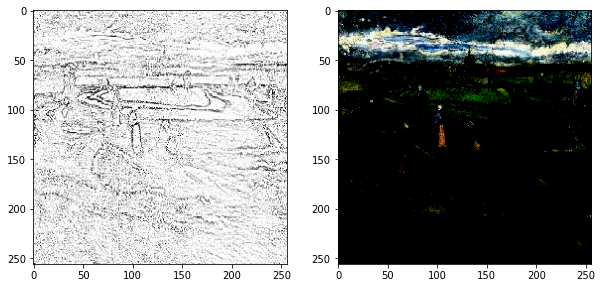

In [28]:
plt.figure(figsize=(10, 10))
input_image, real_image = load_image_train(stiched_images_paths[0])
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(real_image)

plt.show()


### Building the Pipeline

In [29]:
train_dataset = tf.data.Dataset.from_tensor_slices(stiched_images_paths)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [30]:
try:
  test_dataset = tf.data.Dataset.list_files(stiched_images_paths)
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(stiched_images_paths)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Saving the Dataset

In [32]:
from os import mkdir

directories = [DATASET_SAVE_PATH, DATASET_SAVE_PATH + '/train', DATASET_SAVE_PATH + '/test']

for directory in directories:
    try:
        mkdir(directory)
    except FileExistsError:
        print('Directory already exists')
        pass 
    except Exception as e:
        print(e)

In [33]:
tf.data.experimental.save(
    train_dataset, DATASET_SAVE_PATH + '/train', compression='GZIP'
)
with open(DATASET_SAVE_PATH + '/train' + '/element_spec', 'wb') as out_:  # also save the element_spec to disk for future loading
    pickle.dump(train_dataset.element_spec, out_)
    

tf.data.experimental.save(
    test_dataset, DATASET_SAVE_PATH + '/test', compression='GZIP'
)
with open(DATASET_SAVE_PATH + '/test' + '/element_spec', 'wb') as out_:  # also save the element_spec to disk for future loading
    pickle.dump(test_dataset.element_spec, out_)

### Loading the Dataset

In [34]:
with open(DATASET_SAVE_PATH + '/train' + '/element_spec', 'rb') as in_:
    es = pickle.load(in_)

loaded_train_dataset = tf.data.experimental.load(
    DATASET_SAVE_PATH + '/train', es, compression='GZIP'
)


with open(DATASET_SAVE_PATH + '/test' + '/element_spec', 'rb') as in_:
    es = pickle.load(in_)

loaded_test_dataset = tf.data.experimental.load(
    DATASET_SAVE_PATH + '/test', es, compression='GZIP'
)

### Testing the Integrity of the Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


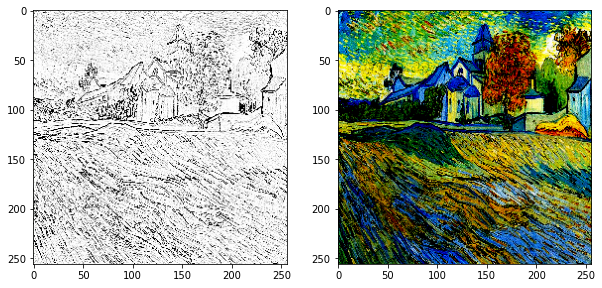

In [41]:

for item in loaded_test_dataset.shuffle(10).take(1):
    input_image, real_image = item
    input_image = np.squeeze(input_image)
    real_image = np.squeeze(real_image)

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(input_image, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.imshow(real_image)

    plt.show()